In [1]:
%matplotlib inline
from IPython.display import *
import theano
import theano.tensor as T
import numpy as np

Couldn't import dot_parser, loading of dot files will not be possible.


# NLP with Theano

# Introduction to Neural Networks

<img src="http://upload.wikimedia.org/wikipedia/commons/thumb/e/e4/Artificial_neural_network.svg/560px-Artificial_neural_network.svg.png"/>

# Vectorised Notations

Weighted sum of input:

$$
\begin{align}
x ^\top w &=
\left[\begin{matrix}
x_1\\
\vdots\\
x_d
\end{matrix}\right]^\top
\left[\begin{matrix}
w_1\\
\vdots\\
w_d
\end{matrix}\right] = \sum_i w_ix_i  \\
x ^\top W &=
\left[\begin{matrix}
x_1\\
\vdots\\
x_d
\end{matrix}\right]^\top
\left[\begin{matrix}
w_{1,1} & \cdots & w_{1,d'}\\
\vdots & \ddots & \vdots\\
w_{d,1} & \cdots & w_{d,d'}
\end{matrix}\right]
 = 
\left[\begin{matrix} \sum_i w_{i,1}x_i & \cdots & \sum_i w_{i,d'}x_i \end{matrix} \right]
\end{align}
$$

Applying functions to matrices:

$$
f(X) = 
f\left(\left[\begin{matrix}
r_{0,0} & \cdots & r_{0,d}\\
&\vdots& \\
r_{|D|,0} & \cdots & r_{|D|,d}
\end{matrix}\right]\right) =
\left[\begin{matrix}
f(r_{0,0}) & \cdots & f(r_{0,d})\\
&\vdots& \\
f(r_{|D|,0}) & \cdots & f(r_{|D|,d})
\end{matrix}\right]
$$

#Logistic Regression / Perceptron / Single-layer Neural Network

Sigmoid function for binary classification:

$$f(x) = \frac{1}{1-e^{-x ^\top W}}$$

Softmax if more than one label:

$$
\frac{1}{ \sum_{j=1}^{L}{e^{ x ^\top W_j }} }
\begin{bmatrix}
e^{ x ^\top W_1 } \\
e^{ x ^\top W_2 } \\
\vdots \\
e^{ x ^\top W_L } \\
\end{bmatrix}
$$


To optimise, log-loss function:

$$E(X,y) = - \frac{1}{n} \sum_{i=1}^n  \left( y_i \log(f(X_i)) + (1 - y_i) \log(1 - f(X_i))\right)$$

## Learn an autoencoder

<img src="http://blog.wtf.sg/wp-content/uploads/2014/05/Screenshot-from-2014-05-09-233355.png">

In [31]:
# Prepare symbols
X = T.matrix('X')
W_hidden = theano.shared(np.random.randn(8,3))
b_hidden = theano.shared(np.random.randn(3))
b_output = theano.shared(np.random.randn(8))

X,W_hidden,b_hidden # Symbolic elements

(X, <TensorType(float64, matrix)>, <TensorType(float64, vector)>)

In [32]:
# Feedforward
hidden_layer = T.nnet.sigmoid(T.dot(X,W_hidden) + b_hidden)
output_layer = T.nnet.softmax(T.dot(hidden_layer,W_hidden.T) + b_output)  

hidden_layer,output_layer # Symbolic elements

(sigmoid.0, Softmax.0)

In [33]:
# Define cost.
cross_entropy = - T.mean(
    T.sum(X*T.log(output_layer) + (1-X)*T.log(1-output_layer),axis=1) # Sum cross-entropy across each training example
)

loss = cross_entropy + 0.001 * T.sum(W_hidden**2) # Add an L2 penalty

## Automatic Differentiation

In Theano, you can call ``T.grad`` on the expression with respect to (``wrt=``) the parameters in it.

Once the gradients are computed, it's just the usual gradient descent step:

$$w_i \leftarrow w_i - \varepsilon \Delta w_i$$

In [34]:
# Calculate gradients on all tunable parameters
parameters = [W_hidden,b_hidden,b_output]
gradients = T.grad(loss,wrt=parameters)

# Create update pairs
updates = [ (w, w - 0.1 * delta_w) for w,delta_w in zip(parameters,gradients)]

# Compile expression.
train = theano.function(
        inputs=[X],
        updates = updates
)

In [35]:
data = np.eye(8,dtype=np.int32)
data

array([[1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1]], dtype=int32)

In [40]:
print "Training..."
for _ in xrange(100000):
    train(data)

Training...


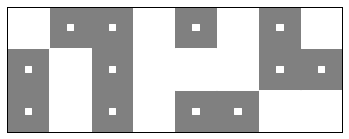

In [41]:
representation = theano.function(
    inputs=[X],
    outputs=hidden_layer
)

import autoencoder
autoencoder.hinton(representation(np.eye(8)))

# Language Models using Neural Networks

Language model - Probability of a sequence of words in a language:

$$P(w_1,\cdots,w_N)$$

Approximation using a $k$-sized window:

$$P(w_1,\cdots,w_N) \approx \prod_{i=1}^{N} P(w_t|w_{t-1},w_{t-2},\dots,w_{t-k})$$

We can create a neural network that takes in the previous $k$ words, and outputs the probabilities of all $|V|$ words:

$$P(w_t|w_{t-1},w_{t-2},\dots,w_{t-k}) := f(w_t,w_{t-1},w_{t-2},\dots,w_{t-k})$$

##Basic Language Model
###[Bengio, Yoshua, et al. "Neural probabilistic language models." Innovations in Machine Learning. Springer Berlin Heidelberg, 2006. 137-186.](http://machinelearning.wustl.edu/mlpapers/paper_files/BengioDVJ03.pdf)

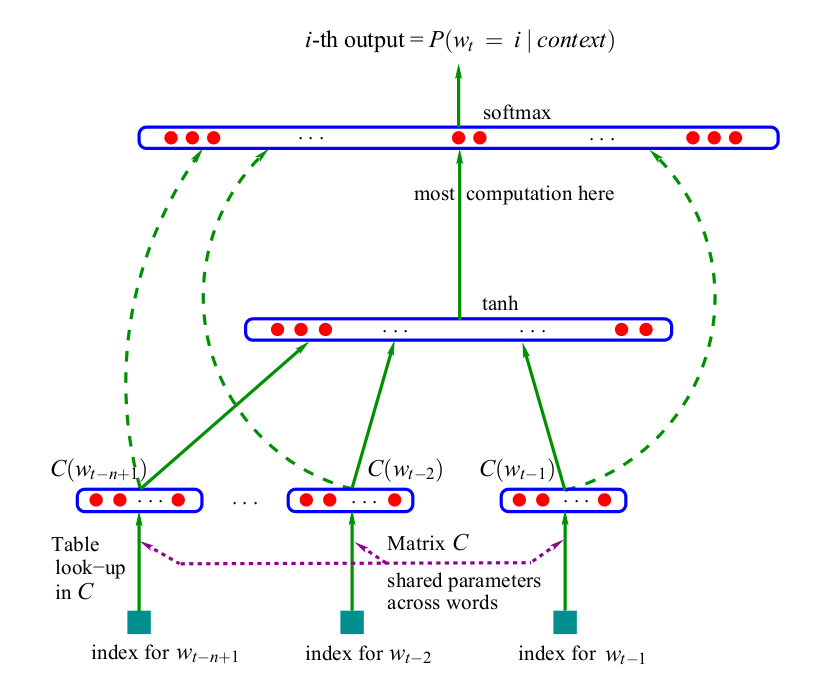

In [9]:
Image('images/bengiomodel.png')

### Using a table lookup instead of one-hot vectors
Using a one-hot vector to represent words allows us to continue using matrix multiplications, but it is equivalent to just extracting a single row out of the word-to-vector table.

$$
\left[\begin{matrix}
0 \\
\vdots \\
1 \\
\vdots\\
0
\end{matrix} \right]^{\top}
\underbrace{\left[\begin{matrix}
r_{0,0} & \cdots & r_{0,d}\\
&\vdots& \\
r_{i,0} & \cdots & r_{i,d} \\
&\vdots&\\
r_{|V|,0} & \cdots & r_{|V|,d}
\end{matrix} \right]}_{C}
= \left[r_{i,0} ~~ \cdots ~~ r_{i,d}\right] = C_i
$$



In a bag-of-words model, the input is no longer one-hot, but the same principle applies: just lookup the words in the bag and sum up their vectors

$$
\left[\begin{matrix}
0 \\
\vdots \\
1 \\
\vdots\\
1\\
\vdots\\
0
\end{matrix} \right]^{\top}
\underbrace{\left[\begin{matrix}
r_{0,0} & \cdots & r_{0,d}\\
&\vdots& \\
r_{i,0} & \cdots & r_{i,d} \\
&\vdots&\\
r_{j,0} & \cdots & r_{j,d} \\
&\vdots&\\
r_{|V|,0} & \cdots & r_{|V|,d}
\end{matrix} \right]}_{C}
= \left[r_{i,0} + r_{j,0} ~~ \cdots ~~ r_{i,d} + r_{j,d}\right] = C_i + C_j
$$

Essential thing to remember is that the matrix $C$ is a parameter to be tuned as well.

## Indexing ~~abuse~~ kung-fu

In [10]:
A = T.eye(3)
A[[0,2,1,0]].eval() # eval() lets me evaluate simple expressions without doing the whole theano.function() dance

array([[ 1.,  0.,  0.],
       [ 0.,  0.,  1.],
       [ 0.,  1.,  0.],
       [ 1.,  0.,  0.]])

In [11]:
A[[[0,1,2],[2,1,0]]].eval()

array([[[ 1.,  0.,  0.],
        [ 0.,  1.,  0.],
        [ 0.,  0.,  1.]],

       [[ 0.,  0.,  1.],
        [ 0.,  1.,  0.],
        [ 1.,  0.,  0.]]])

## Training a language model

In [39]:
%%bash
wc -l tr.en
head -n 3 tr.en

99000 tr.en
the right to collective bargaining is exactly this , which is to establish a mechanism to ensure dialogues between employers and employees instead of unilateral talks or appeals .
applications are now invited from stall operators who intend to sell hand-made arts and crafts items and nostalgic items , or other variety of goods ; or to operate arts-related activities such as sketching and painting at the promenade .
nevertheless , there were others , such as the tenants ' organization " snails without shells , " which were originally well received but later ran out of steam and were unable to attain a high position .


In [13]:
vocab = set(w for line in open('tr.en')
              for w in line.strip().split())
vocab_size = len(vocab)
vocab_size

48754

In [14]:
# Index mapping
word2idx = { w:i for i,w in enumerate(vocab) }
word2idx.iteritems().next() # Gives me word to word-index

('fawn', 0)

In [15]:
def indexify(line):
    return [ word2idx[w] for w in line.split() ]
from itertools import izip
for _,line in izip(xrange(3),open('tr.en')): print indexify(line)

[46084, 37138, 25882, 28731, 14299, 18739, 42176, 38957, 13352, 36135, 18739, 25882, 21943, 41276, 14720, 25882, 9688, 37108, 28569, 31582, 37005, 15209, 35927, 22767, 33574, 19778, 22780, 33701, 498]
[13043, 47667, 4007, 27072, 11395, 47550, 47352, 21960, 745, 25882, 1875, 29008, 19487, 37005, 29045, 27451, 37005, 23830, 27451, 13352, 22780, 24320, 42426, 22767, 32592, 17531, 22780, 25882, 6193, 21074, 34994, 37448, 13606, 27245, 37005, 26975, 33227, 46084, 41463, 498]
[8842, 13352, 14650, 19307, 44975, 13352, 37448, 13606, 46084, 44804, 2531, 44699, 10840, 35815, 10360, 45211, 13352, 10840, 36135, 19307, 878, 30186, 40071, 21251, 10154, 46054, 11555, 22767, 40041, 37005, 19307, 27793, 25882, 46615, 41276, 14526, 45507, 498]


### Window of tokens

In [16]:
T.arange(10).eval()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

In [17]:
def window_indexer(window_size,string_length): # Function returns a symbol
    window = T.arange(window_size)
    window_start = T.arange(string_length-(window_size-1)).dimshuffle(0,'x')
    return window_start + window
window_indexer(5,10).eval()

array([[0, 1, 2, 3, 4],
       [1, 2, 3, 4, 5],
       [2, 3, 4, 5, 6],
       [3, 4, 5, 6, 7],
       [4, 5, 6, 7, 8],
       [5, 6, 7, 8, 9]], dtype=int8)

### To Theano!

In [18]:
# Prepare symbols...
vector_dim = 10
window_size = 5

# This represents the variable holding the sequence of token indices
idxs = T.ivector('idxs')

# Lookup table matrix
lookup_table = theano.shared(np.random.randn(vocab_size+1,vector_dim),name="lookup") # +1 for padding

In [19]:
idxs_padded = T.concatenate([[-1]*(window_size-1),idxs])
windows = window_indexer(window_size,idxs_padded.shape[0])
windowed_idxs = idxs_padded[windows]

# Let's see what this looks like
windowed_idxs.eval({idxs:[50,10,20,31,41]})

array([[-1, -1, -1, -1, 50],
       [-1, -1, -1, 50, 10],
       [-1, -1, 50, 10, 20],
       [-1, 50, 10, 20, 31],
       [50, 10, 20, 31, 41]])

In [20]:
# Extract features from the lookup table
X = windowed_idxs[:,:-1]
features = lookup_table[X] # sentence length x window_size - 1 x vector_dim
# Concatenate the feature vectors together 
features = features.reshape((windowed_idxs.shape[0],(window_size - 1) * vector_dim))

# Let's take a look at the output
features.eval({idxs:[50,10,20,31,41]}).shape

(5, 40)

In [38]:
# Let's use these as labels
Y = windowed_idxs[:,-1]
Y.eval({idxs:[50,10,20,31,41]})

array([50, 10, 20, 31, 41])

### Building the network

In [22]:
hidden_size = 50
W_hidden = theano.shared(np.random.randn((window_size - 1) * vector_dim,hidden_size),name="W_hidden")
b_hidden = theano.shared(np.zeros((hidden_size,)),name="b_hidden")
W_output = theano.shared(np.zeros((hidden_size,vocab_size+1)),name="W_output")
b_output = theano.shared(np.zeros((vocab_size+1)),name="b_output")

In [23]:
# Network
hiddens = T.tanh(T.dot(features,W_hidden) + b_hidden)
outputs = T.nnet.softmax(T.dot(hiddens,W_output) + b_output)

cost = -T.mean(T.log(outputs[T.arange(Y.shape[0]),Y])) # -ve log likelihood

In [24]:
parameters = [lookup_table,W_hidden,b_hidden,W_output,b_output]
gradients  = T.grad(cost,wrt=parameters)

train = theano.function(
        inputs = [idxs],
        outputs = cost,
        updates = [ (p,p -  0.01 * g) for p,g in zip(parameters,gradients) ],
    )

In [25]:
#for line in open('tr.en'):train(indexify(line))

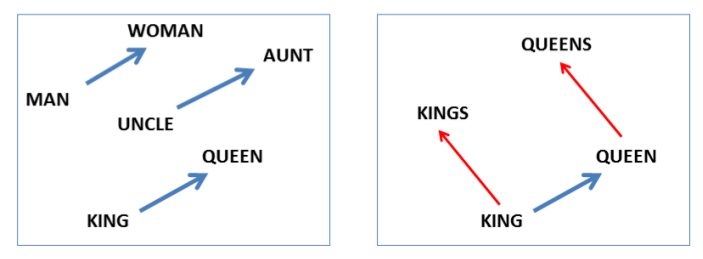

In [26]:
Image('images/wordvec.png')

# Ideas going forward..

1. [Kaggle NLP Challenge: Billion Word Imputation](http://www.kaggle.com/c/billion-word-imputation)
2. [Facebook bAbI Project](https://research.facebook.com/researchers/1543934539189348)
3. [Sequence-to-sequence learning](http://arxiv.org/abs/1409.3215)


# Resources

1. [Geoffrey Hinton's class](https://www.coursera.org/course/neuralnets)
2. [Hugo Larochelle's online course](http://info.usherbrooke.ca/hlarochelle/neural_networks/content.html)
3. [Theano tutorials and documentation](http://deeplearning.net/software/theano/)
4. [Manning and Socher's talk: NLP without magic](http://nlp.stanford.edu/courses/NAACL2013/)